In [3]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [2]:
pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 8.6 MB/s 
     |████████████████████████████████| 2.2 MB 40.8 MB/s 
     |████████████████████████████████| 1.3 MB 67.3 MB/s 
     |████████████████████████████████| 33.8 MB 367 kB/s 
     |████████████████████████████████| 1.1 MB 54.3 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 1.0 MB 58.9 MB/s 
     |████████████████████████████████| 764 kB 76.2 MB/s 
     |████████████████████████████████| 1.0 MB 40.4 MB/s 
     |████████████████████████████████| 133 kB 70.7 MB/s 
     |████████████████████████████████| 232 kB 61.5 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
     |████████████████████████████████| 1.6 MB 51.1 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 133 kB 62.2 MB/s 
  Created wheel for metaphone: filen

In [4]:
df = pd.read_excel('Airlines+Data.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (96, 2)


,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
5,1995-06-01,135
6,1995-07-01,148
7,1995-08-01,148
8,1995-09-01,136
9,1995-10-01,119


In [5]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [6]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

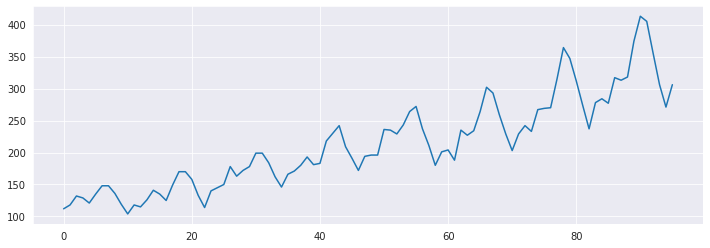

In [7]:
df.Passengers.plot(figsize=(12,4))

In [8]:
df.shape

(96, 2)

In [11]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [12]:
df.nunique()

Month         96
Passengers    80
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [14]:
df[df.duplicated()].shape

(0, 2)

In [15]:
df[df.duplicated()]

,Month,Passengers


In [16]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [17]:
df.rename({'Month':'Date'},axis=1, inplace=True)

In [18]:
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [20]:
df1.head()

,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [21]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") 
df["year"] = df.Date.dt.strftime("%Y") 
df.head(10)

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995
5,1995-06-01,135,Jun,1995
6,1995-07-01,148,Jul,1995
7,1995-08-01,148,Aug,1995
8,1995-09-01,136,Sep,1995
9,1995-10-01,119,Oct,1995


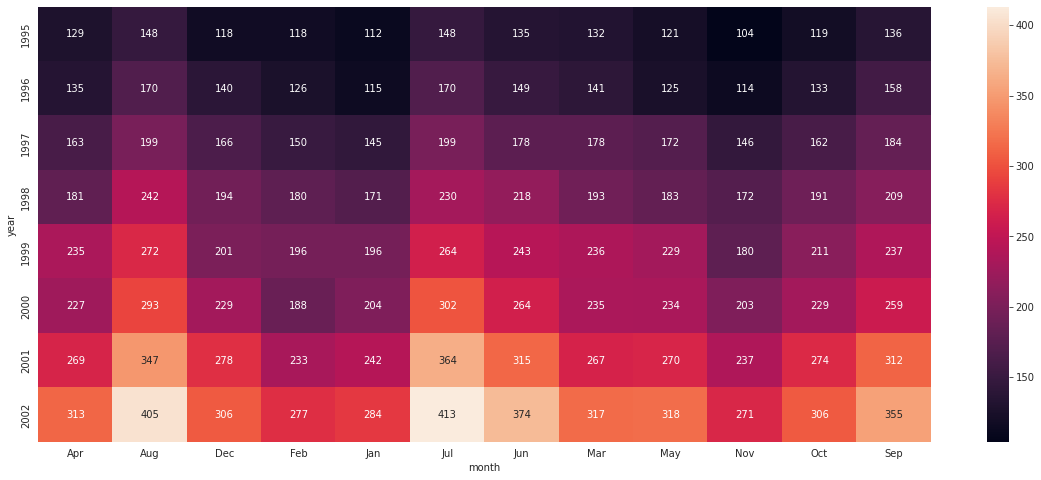

In [22]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

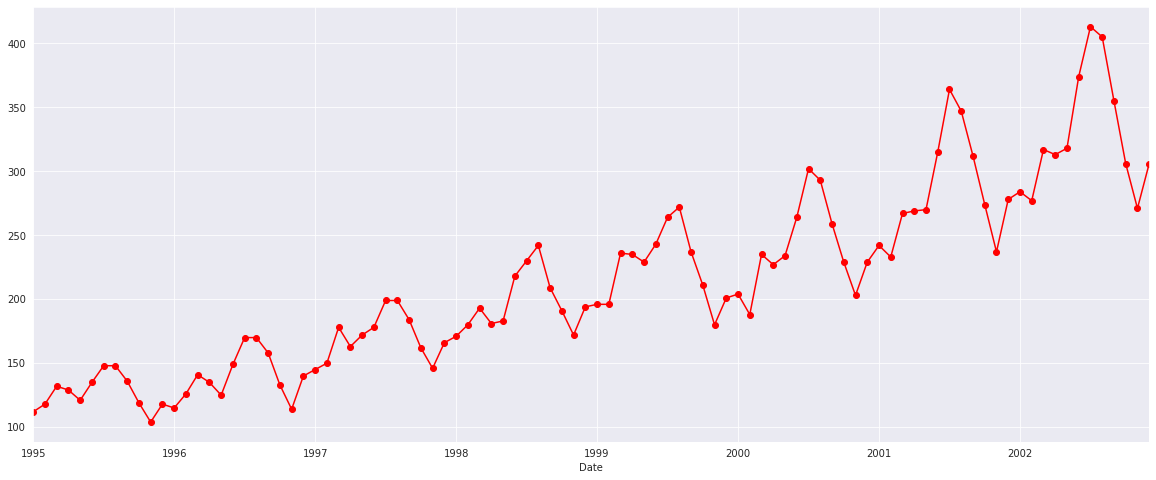

In [23]:
df1['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

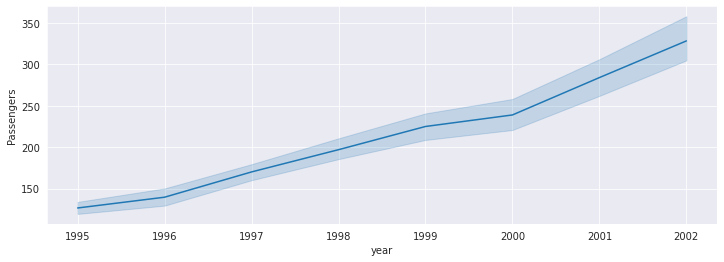

In [24]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

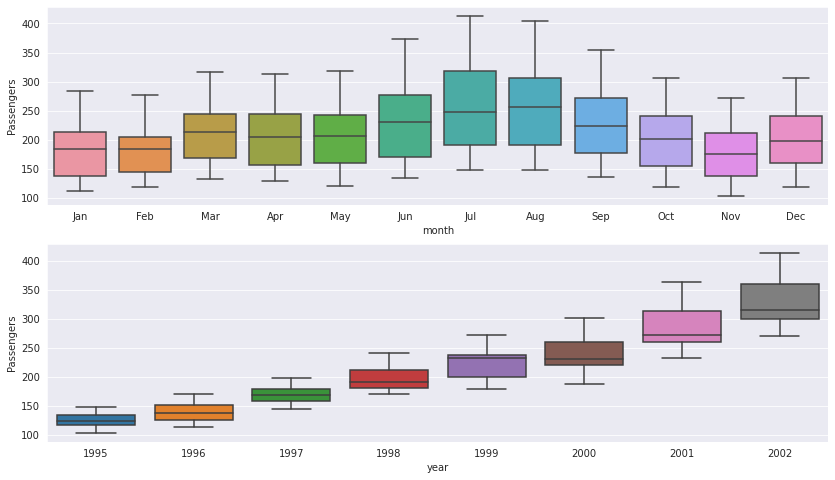

In [25]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

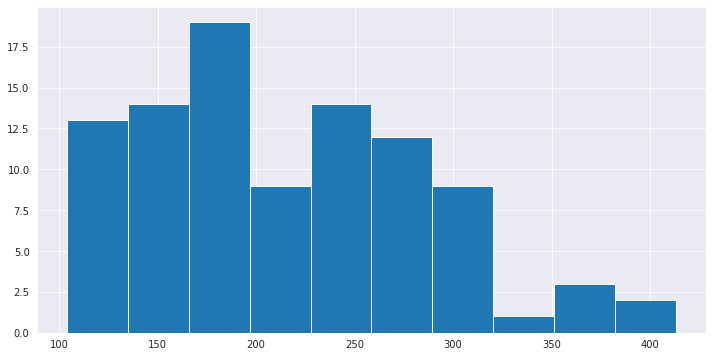

In [26]:
df.Passengers.hist(figsize=(12,6))
plt.show()

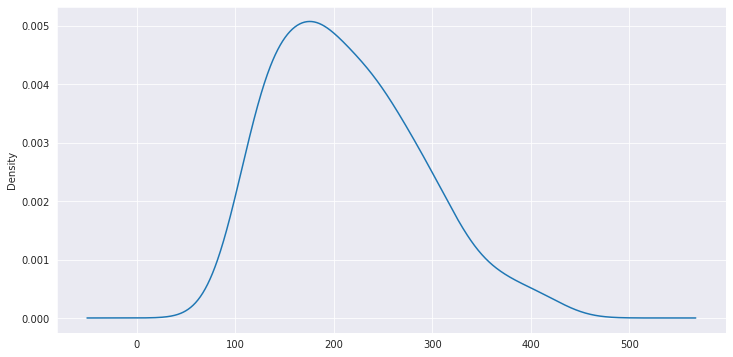

In [27]:
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

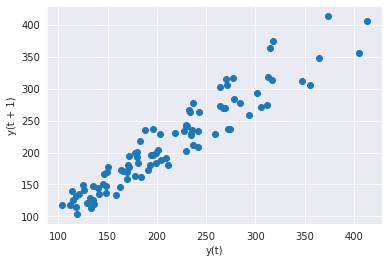

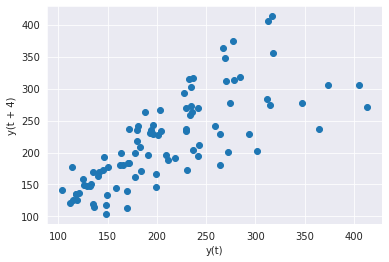

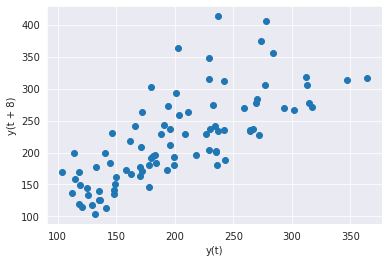

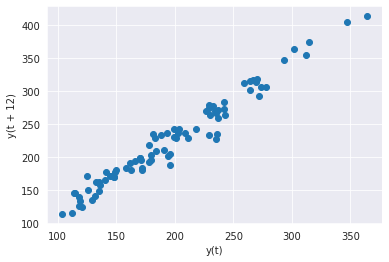

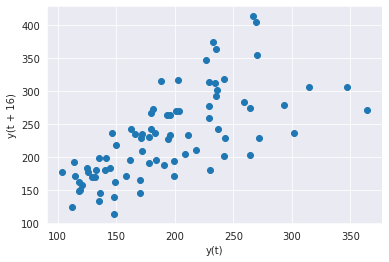

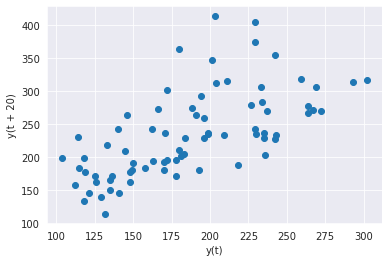

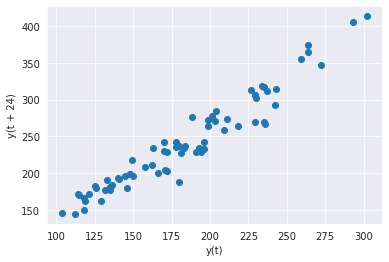

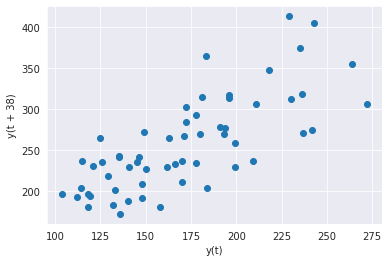

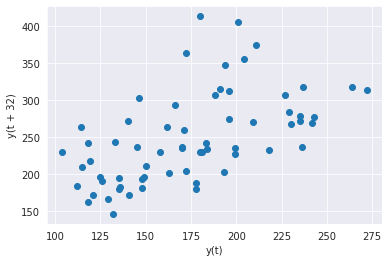

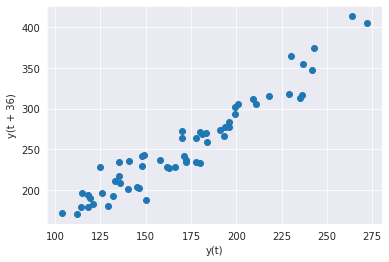

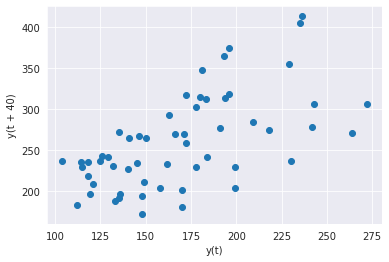

In [28]:
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

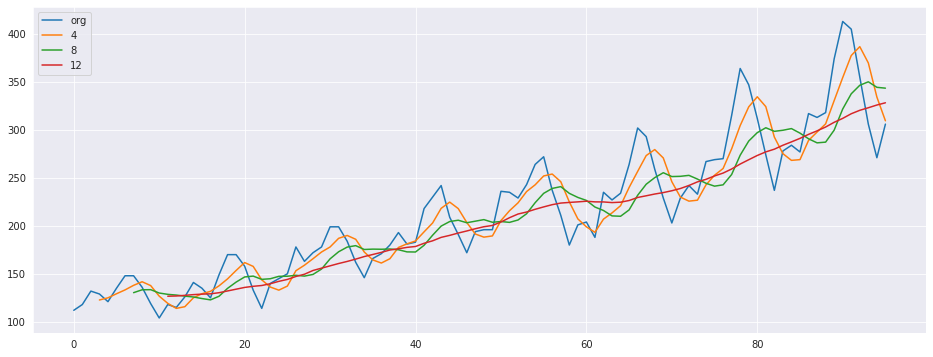

In [29]:
plt.figure(figsize=(16,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

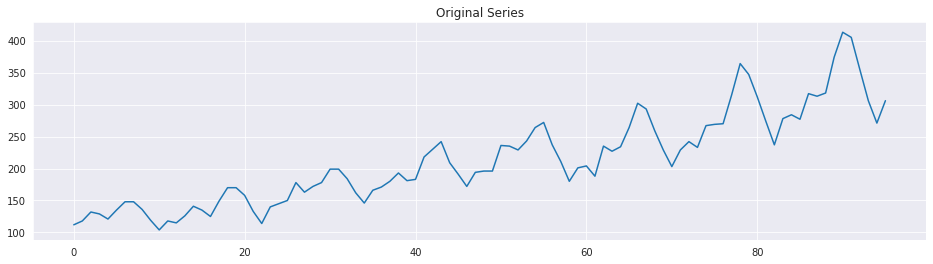

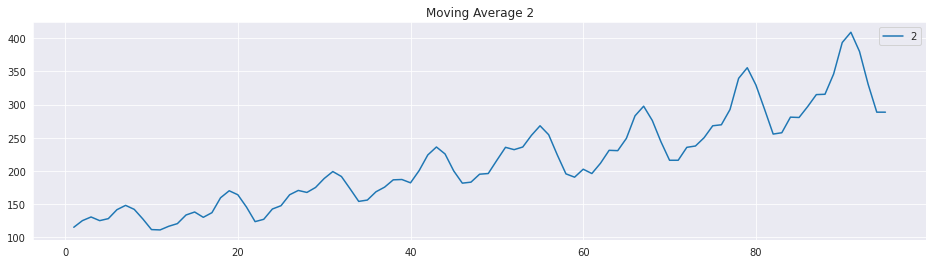

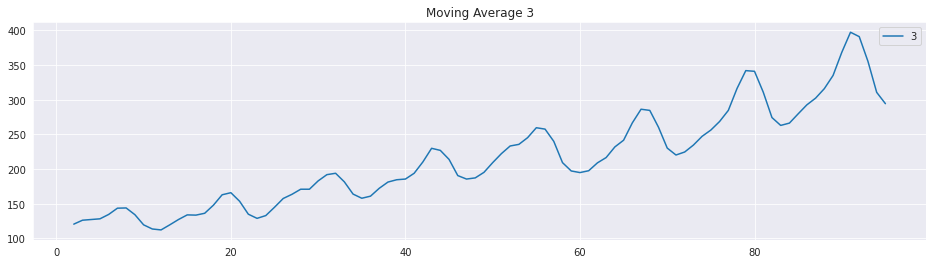

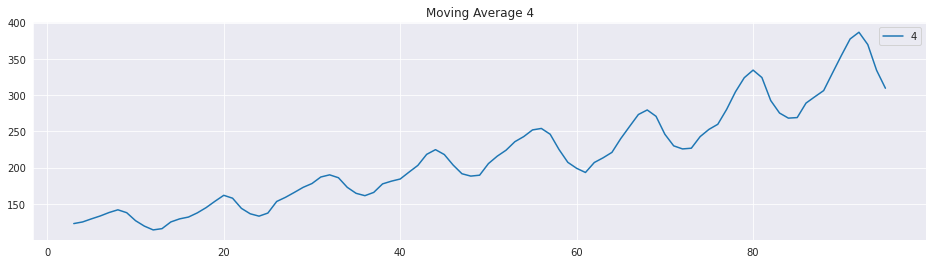

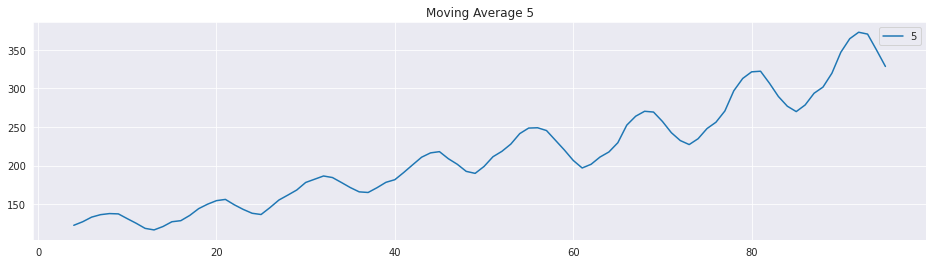

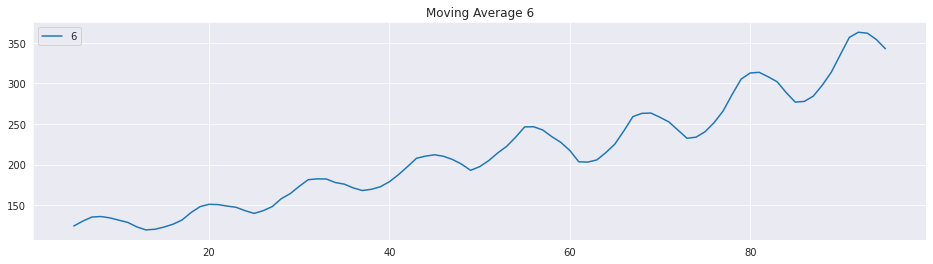

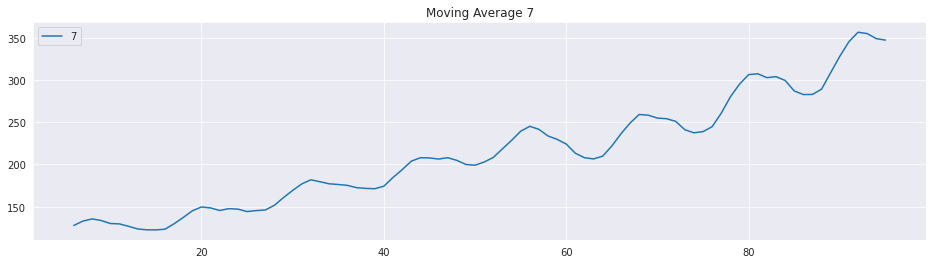

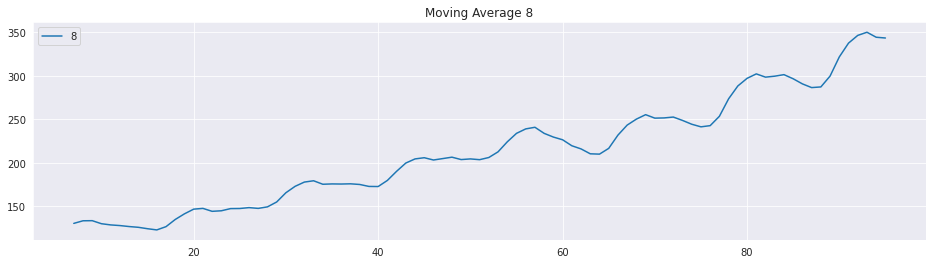

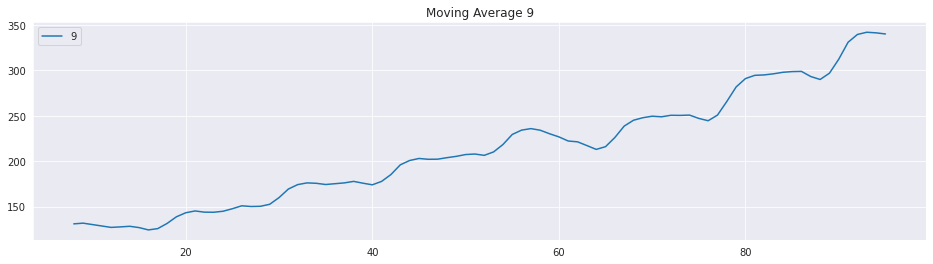

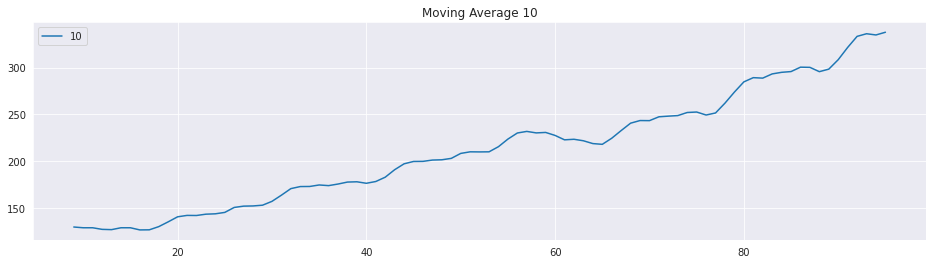

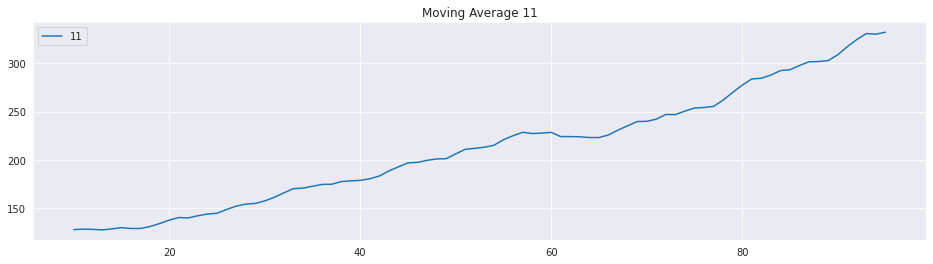

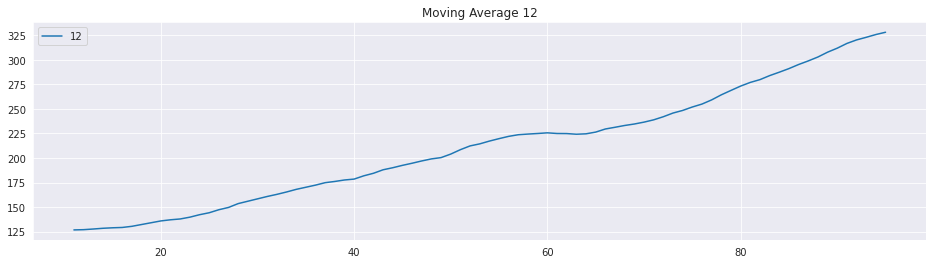

In [30]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

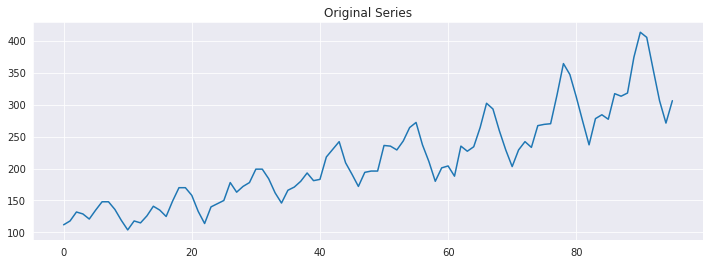

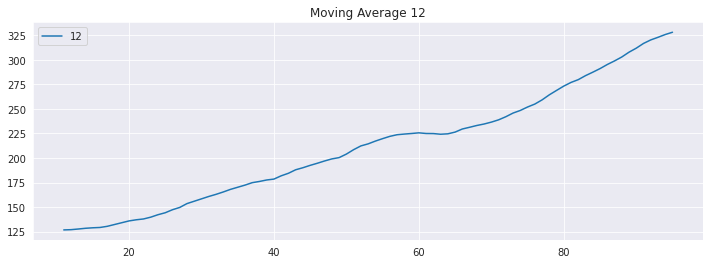

In [31]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

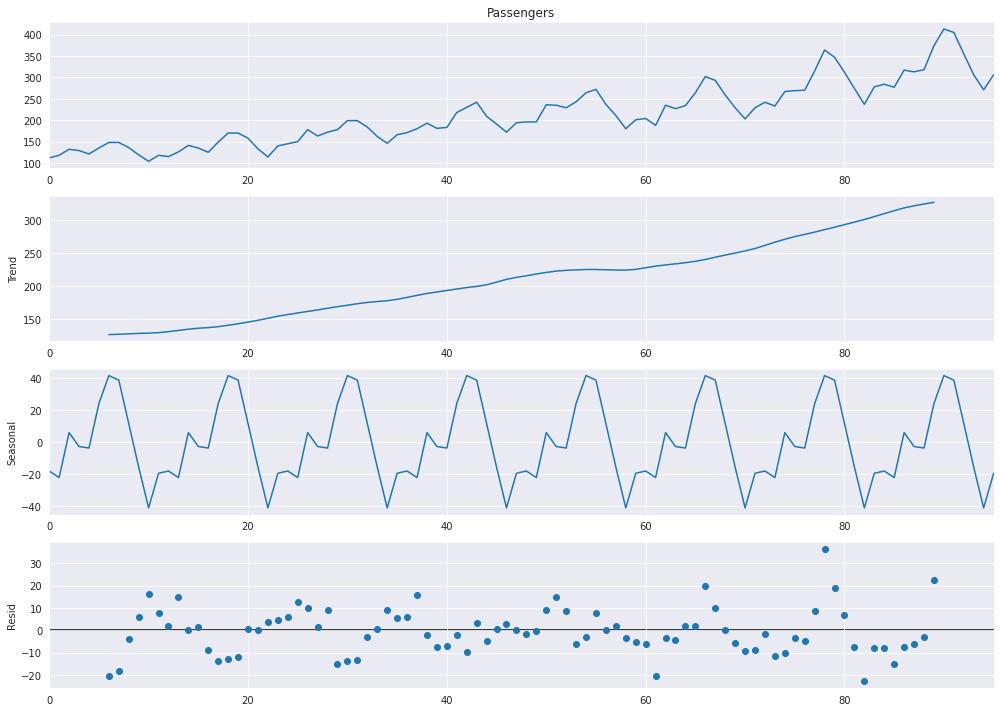

In [32]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

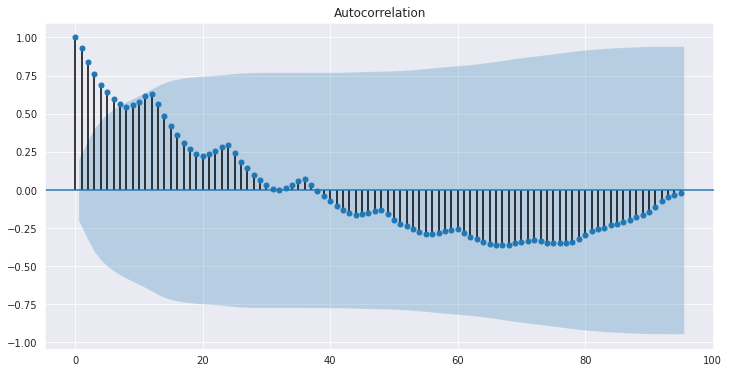

In [33]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

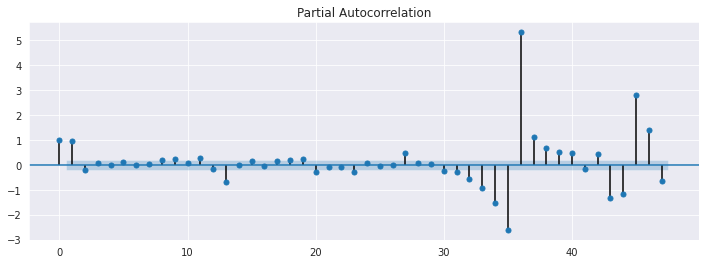

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

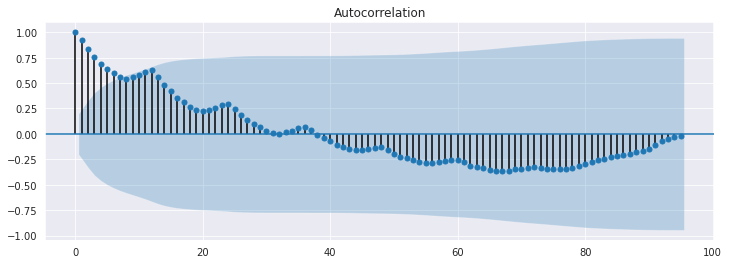

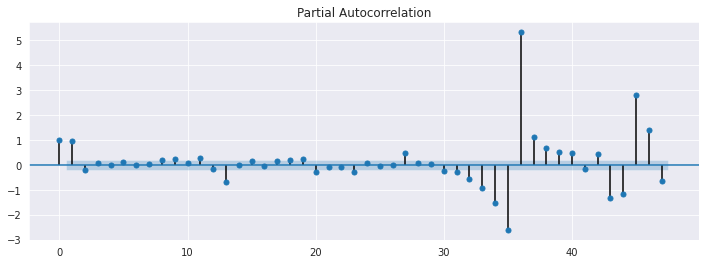

In [35]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

In [37]:
visual = df1.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

,Passengers,date,year,month,week,quarter,day_of_week
0,112,1995-01-01,1995,1,52,1,Sunday
1,118,1995-02-01,1995,2,5,1,Wednesday
2,132,1995-03-01,1995,3,9,1,Wednesday
3,129,1995-04-01,1995,4,13,2,Saturday
4,121,1995-05-01,1995,5,18,2,Monday
5,135,1995-06-01,1995,6,22,2,Thursday
6,148,1995-07-01,1995,7,26,3,Saturday
7,148,1995-08-01,1995,8,31,3,Tuesday
8,136,1995-09-01,1995,9,35,3,Friday
9,119,1995-10-01,1995,10,39,4,Sunday


In [38]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002])

In [39]:
# data 
df_1995 = visual[visual['year']==1995][['month','Passengers']]
df_1995 = df_1995.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1995'})
df_1996 = visual[visual['year']==1996][['month','Passengers']]
df_1996 = df_1996.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1996'})
df_1997 = visual[visual['year']==1997][['month','Passengers']]
df_1997 = df_1997.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1997'})
df_1998 = visual[visual['year']==1998][['month','Passengers']]
df_1998 = df_1998.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1998'})
df_1999 = visual[visual['year']==1999][['month','Passengers']]
df_1999 = df_1999.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1999'})
df_2000 = visual[visual['year']==2000][['month','Passengers']]
df_2000 = df_2000.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2000'})
df_2001 = visual[visual['year']==2001][['month','Passengers']]
df_2001 = df_2001.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2001'})
df_2002 = visual[visual['year']==2002][['month','Passengers']]
df_2002 = df_2002.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2002'})



df_year = df_1995.merge(df_1996,on='month').merge(df_1997,on='month').merge(df_1998,on='month').merge(df_1999,on='month')\
.merge(df_2000,on='month').merge(df_2001,on='month').merge(df_2002,on='month')

# top levels
top_labels = ['1995', '1996', '1997', '1998', '1999','2000','2001','2002']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)']

# X axis value 
df_year = df_year[['1995', '1996', '1997', '1998', '1999','2000','2001','2002']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1995['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1995['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Passengers for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

In [40]:
import calendar
df_m_sa = visual.groupby('month').agg({"Passengers" : "mean"}).reset_index()
df_m_sa['Passengers'] = round(df_m_sa['Passengers'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Passengers'].astype(str) 

df_w_sa = visual.groupby('week').agg({"Passengers" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"Passengers" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Passengers Analysis", "Quarter wise Avg Passengers Analysis", 
                                    "Week wise Avg Passengers Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Passengers'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Passengers'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Passengers'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Passengers Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [41]:
df_dw_sa = visual.groupby('day_of_week').agg({"Passengers" : "mean"}).reset_index()
df_dw_sa.Passengers = round(df_dw_sa.Passengers, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Passengers', title='Avg Passengers vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Passengers',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

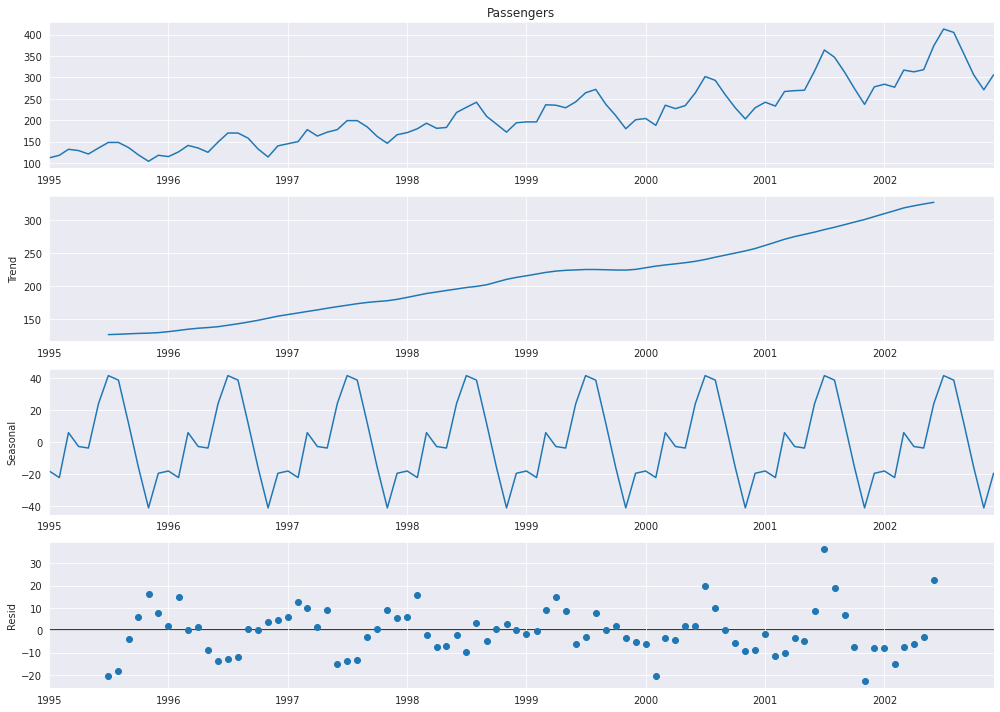

In [42]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [44]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [45]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


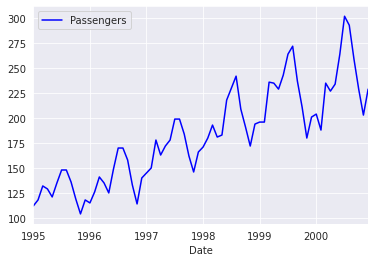

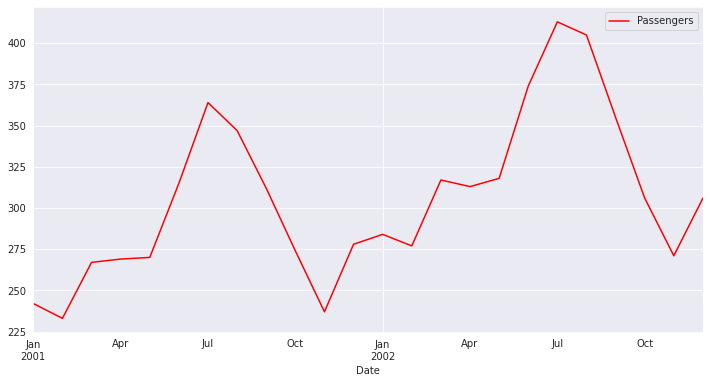

In [46]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

In [47]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [48]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.382283350045057 
 Train Root Mean Squared Error = 19.03177173091111 
 Test Root Mean Squared Error = 91.11325402904487


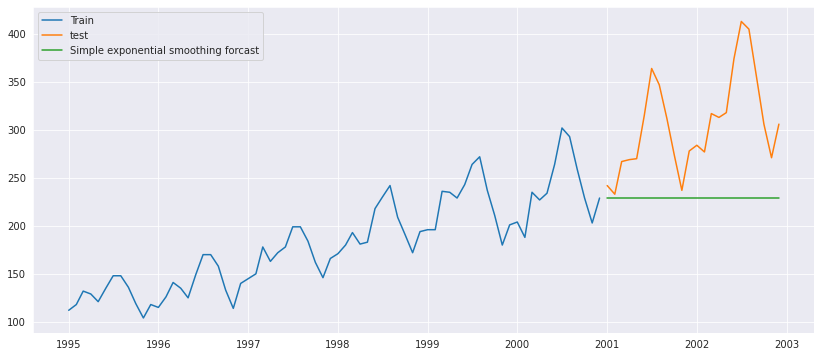

In [50]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [51]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 17.12220875270047 
 Train Root Mean Squared Error = 18.9612923452262 
 Test Root Mean Squared Error = 71.55255166207006


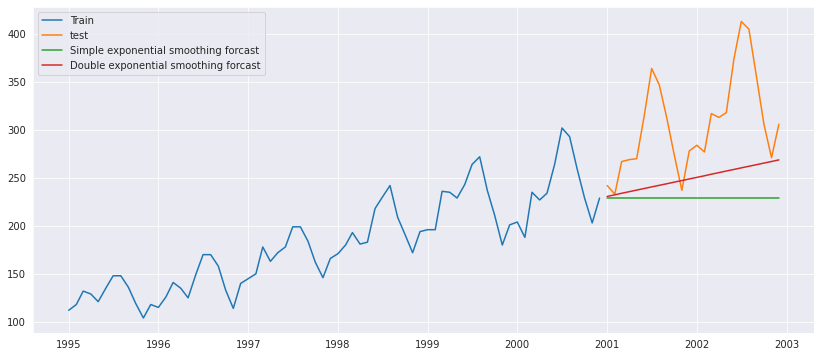

In [52]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [53]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 11.827733506174823 
 Train Root Mean Squared Error = 7.87611550697006 
 Test Root Mean Squared Error = 46.828518857795196


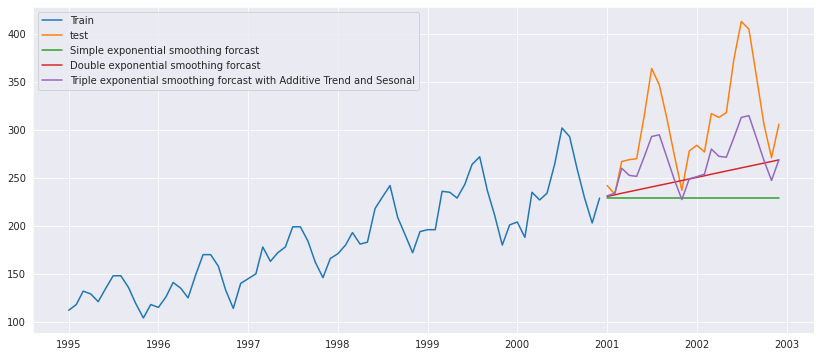

In [54]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [55]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 9.368263038410854 
 Train Root Mean Squared Error = 6.386634442037317 
 Test Root Mean Squared Error = 34.98903880364754


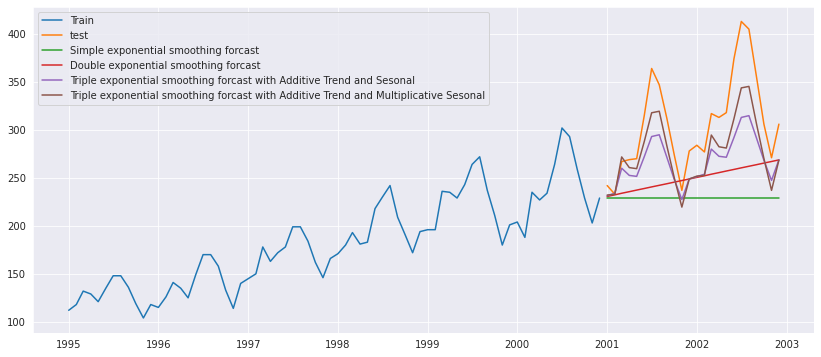

In [56]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [57]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 12.61847809187586 
 Train Root Mean Squared Error = 12.74442252797055 
 Test Root Mean Squared Error = 45.49259086488603


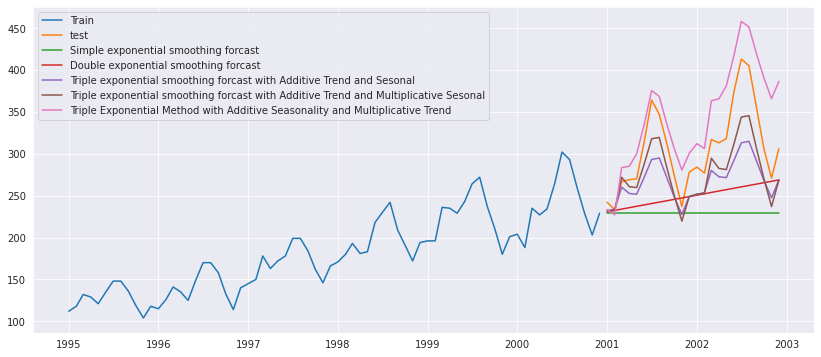

In [58]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

In [59]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 6.03511235766673 
 Train Root Mean Squared Error = 6.396756219048916 
 Test Root Mean Squared Error = 23.058960428274997


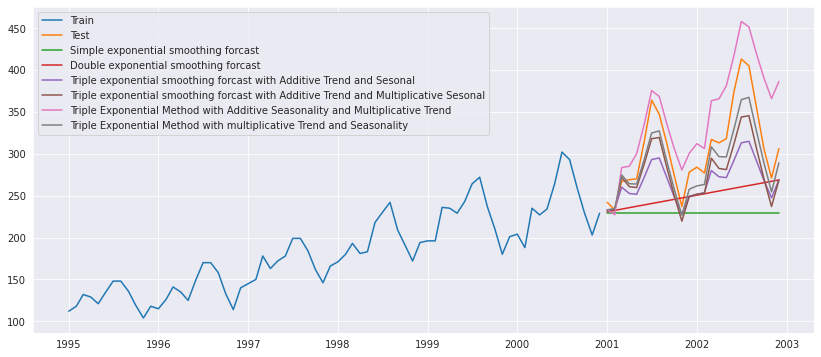

In [60]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [61]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_mul,6.396756,6.035112,23.058960
1,Triple_Exp_mul_ad,6.386634,9.368263,34.989039
2,Triple_Exp_ad,7.876116,11.827734,46.828519
3,Triple_Exp_ad_mul,12.744423,12.618478,45.492591
4,Double_Exp,18.961292,17.122209,71.552552
5,Simple_Exp,19.031772,23.382283,91.113254


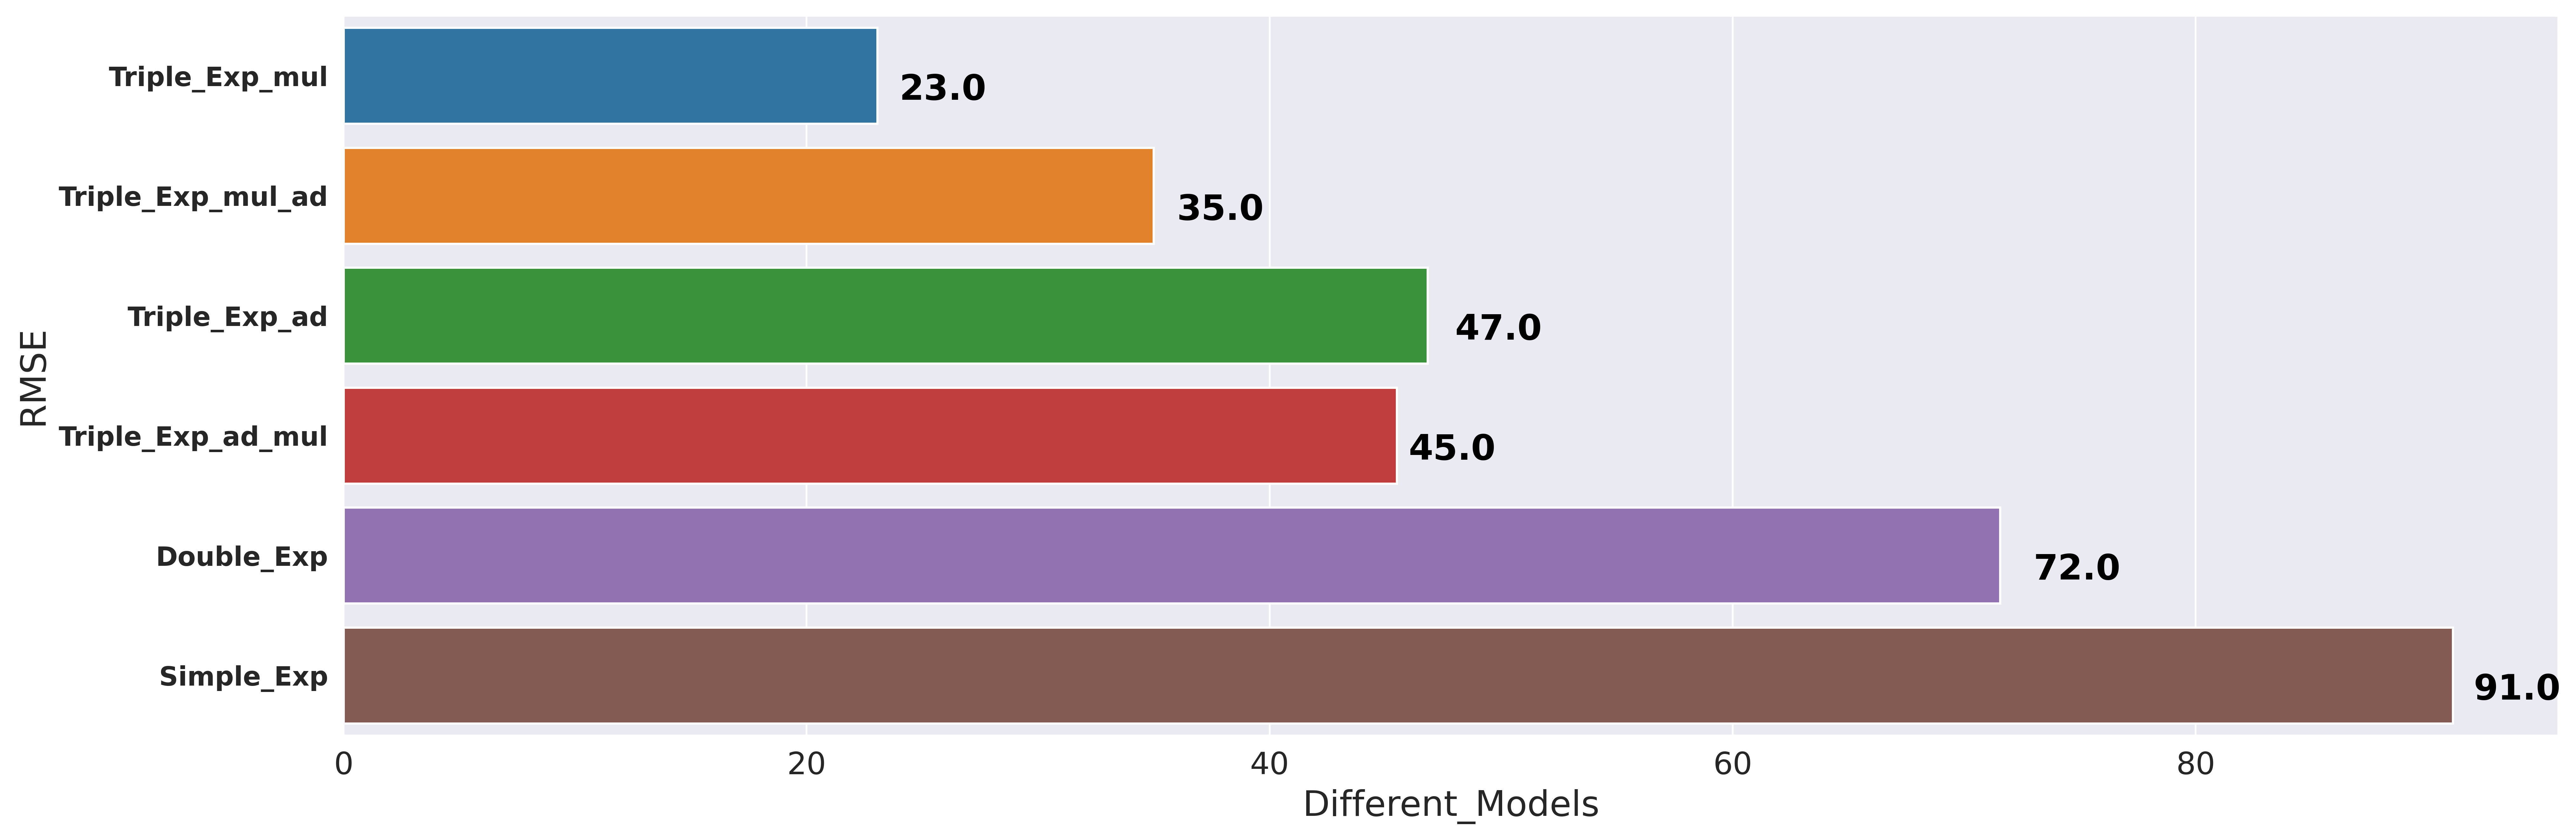

In [62]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

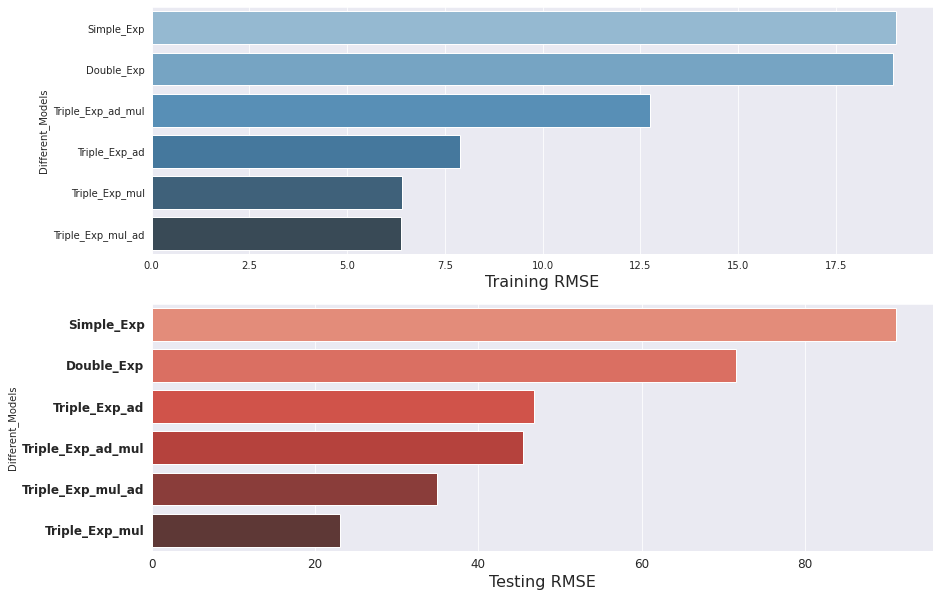

In [63]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

In [64]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

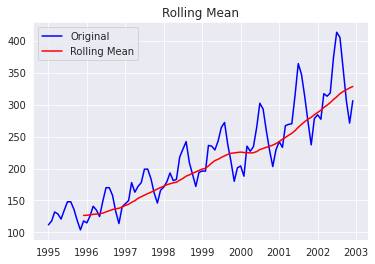

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [65]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [66]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [68]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


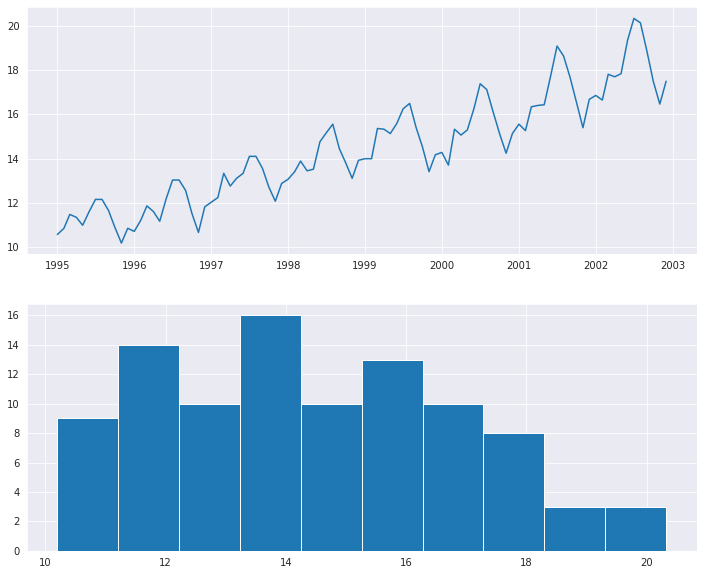

In [69]:
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

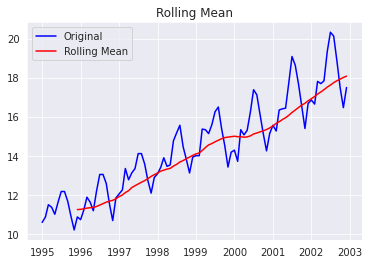

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [70]:
test_stationarity(square_root)

In [71]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


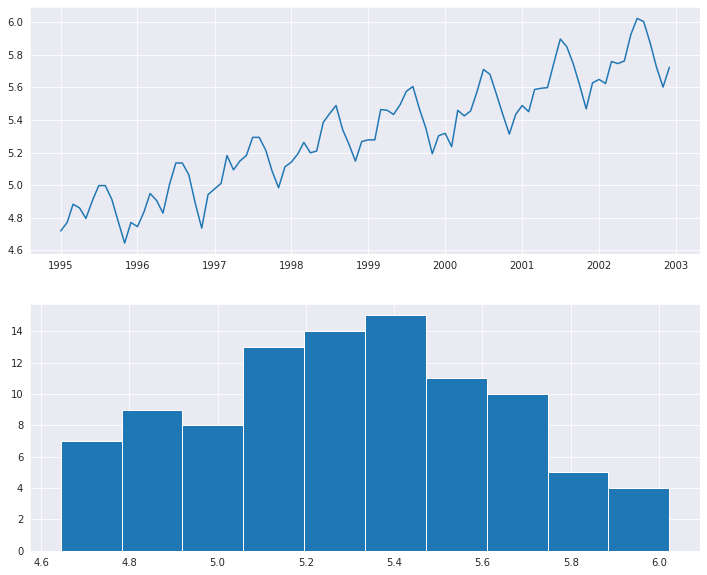

In [72]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

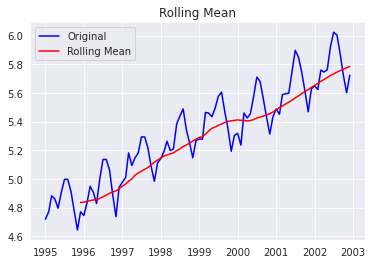

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [73]:
test_stationarity(log)

In [74]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


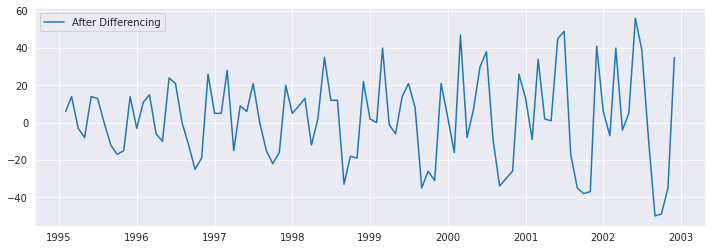

In [75]:
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

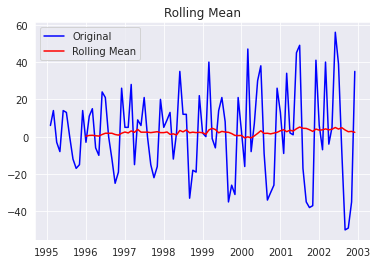

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [76]:
test_stationarity(differencing)

In [77]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


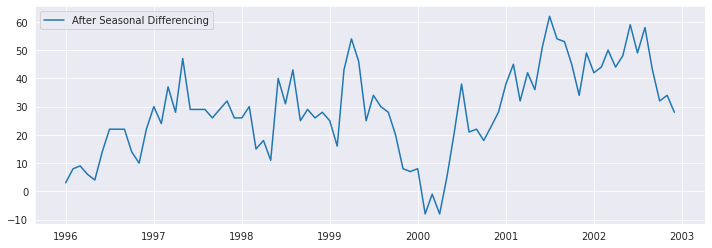

In [78]:
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

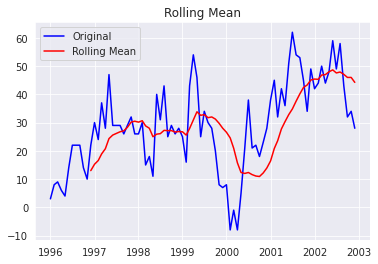

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [79]:
test_stationarity(seasonal_differencing)

In [80]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


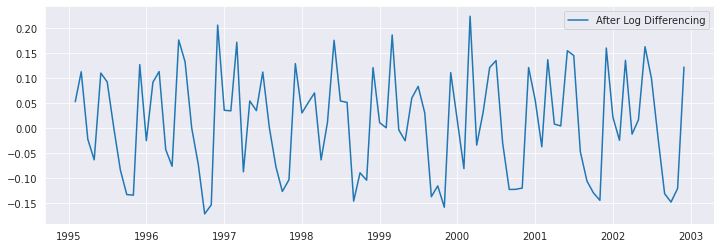

In [81]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

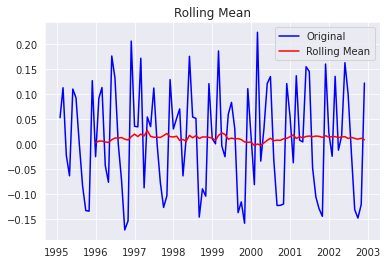

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [82]:
test_stationarity(log_diff)

In [83]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


,Passengers
Date,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791


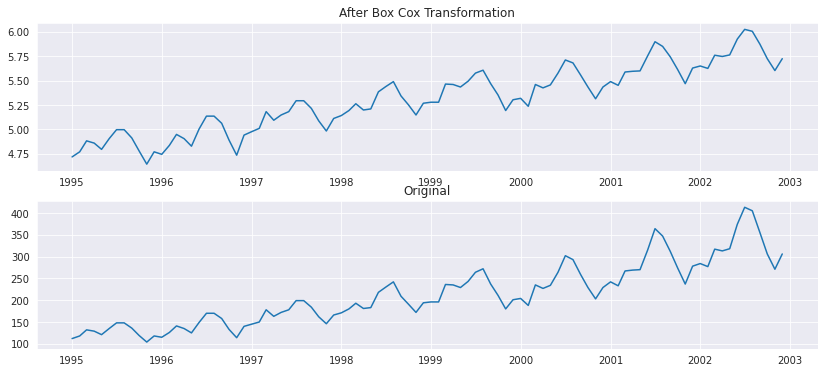

In [84]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

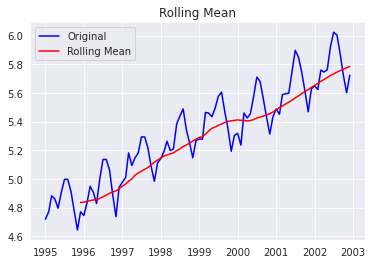

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [85]:
test_stationarity(data_boxcox)

In [86]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


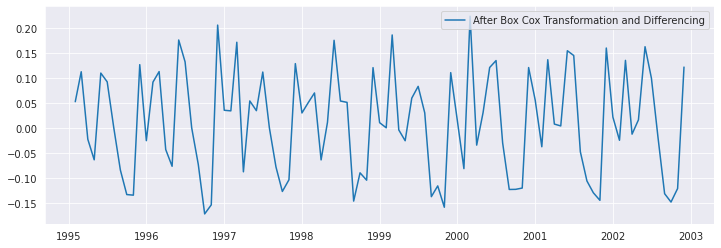

In [87]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

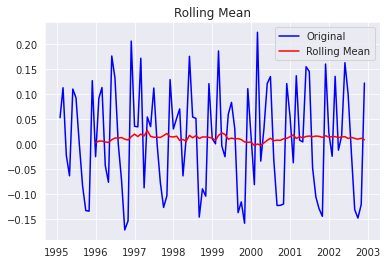

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [88]:
test_stationarity(data_boxcox_diff)

In [89]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


In [90]:
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [91]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [94]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.072


In [95]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [96]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

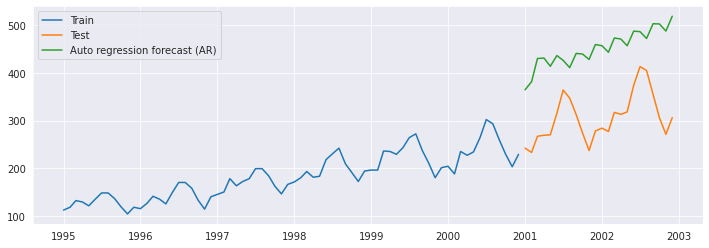

In [97]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [98]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

151.15

In [100]:
model_residual = model_fit.resid
model_residual.mean()

-0.005686100800916972

In [101]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


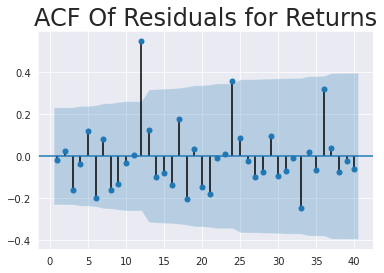

In [102]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

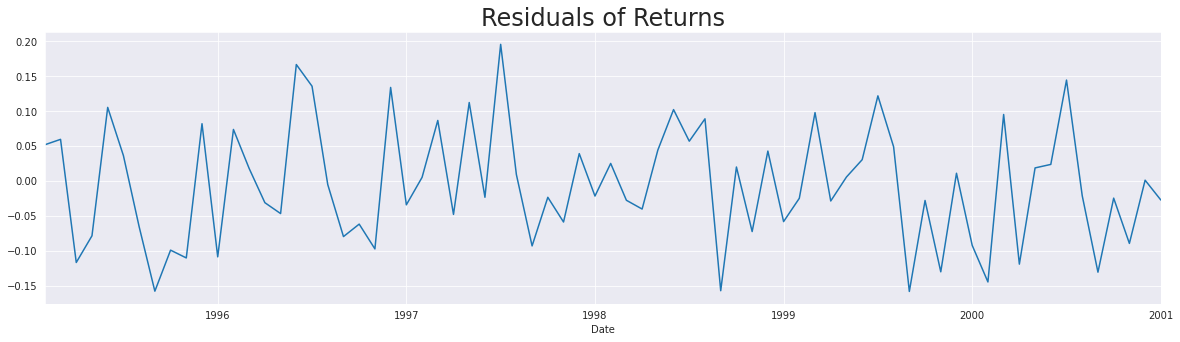

In [103]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [105]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [106]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

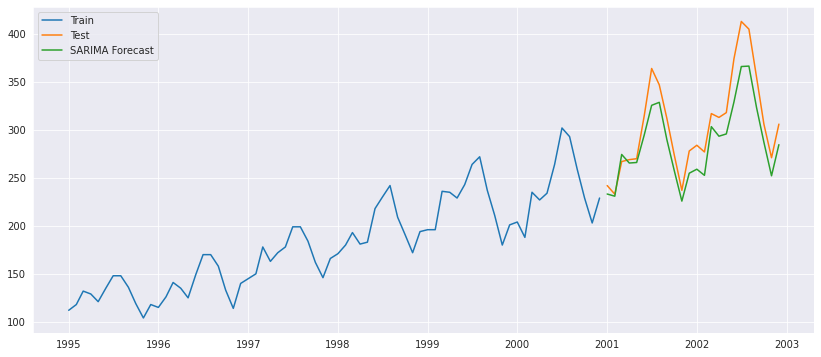

In [107]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [108]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

24.12

In [109]:
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

6.48

In [110]:
model_residual = model_fit.resid
model_residual.mean()

0.03585369051639732

In [111]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


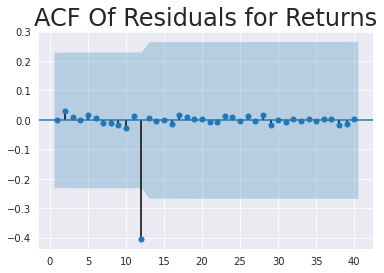

In [112]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

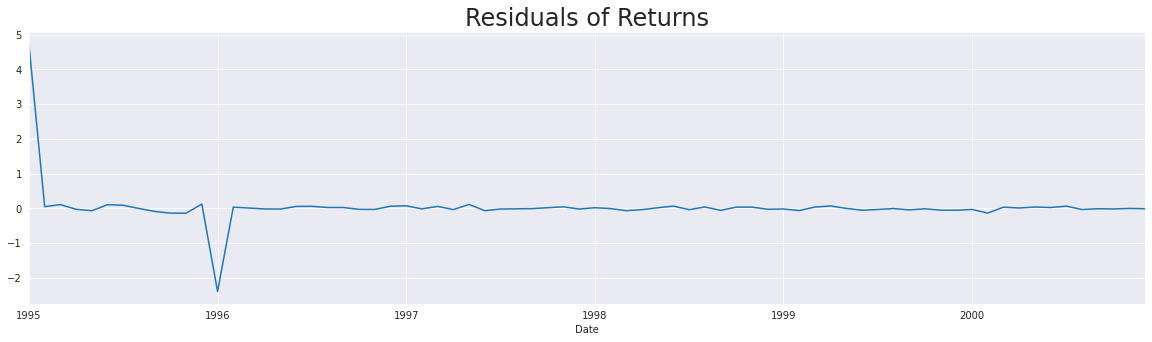

In [113]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [116]:
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-01,118,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-01,132,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-01,129,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-01,121,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-01,355,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-01,306,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-01,271,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [117]:
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [118]:
train_data

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-01,118,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-01,132,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-01,129,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-01,121,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2000-08-01,293,68,4624,Aug,2000,0,0,0,0,0,0,0,1,0,0,0,0,5.680173
68,2000-09-01,259,69,4761,Sep,2000,0,0,0,0,0,0,0,0,1,0,0,0,5.556828
69,2000-10-01,229,70,4900,Oct,2000,0,0,0,0,0,0,0,0,0,1,0,0,5.433722
70,2000-11-01,203,71,5041,Nov,2000,0,0,0,0,0,0,0,0,0,0,1,0,5.313206


In [119]:
test_data

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
72,2001-01-01,242,73,5329,Jan,2001,1,0,0,0,0,0,0,0,0,0,0,0,5.488938
73,2001-02-01,233,74,5476,Feb,2001,0,1,0,0,0,0,0,0,0,0,0,0,5.451038
74,2001-03-01,267,75,5625,Mar,2001,0,0,1,0,0,0,0,0,0,0,0,0,5.587249
75,2001-04-01,269,76,5776,Apr,2001,0,0,0,1,0,0,0,0,0,0,0,0,5.594711
76,2001-05-01,270,77,5929,May,2001,0,0,0,0,1,0,0,0,0,0,0,0,5.598422
77,2001-06-01,315,78,6084,Jun,2001,0,0,0,0,0,1,0,0,0,0,0,0,5.752573
78,2001-07-01,364,79,6241,Jul,2001,0,0,0,0,0,0,1,0,0,0,0,0,5.897154
79,2001-08-01,347,80,6400,Aug,2001,0,0,0,0,0,0,0,1,0,0,0,0,5.849325
80,2001-09-01,312,81,6561,Sep,2001,0,0,0,0,0,0,0,0,1,0,0,0,5.743003
81,2001-10-01,274,82,6724,Oct,2001,0,0,0,0,0,0,0,0,0,1,0,0,5.613128


In [120]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

In [121]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     217.9
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           3.50e-23
Time:                        07:41:27   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             662.1
Df Residuals:                      70   BIC:                             666.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.5243      5.643     19.586      0.000      99.270     121.779
t              1.9830      0.134     14.760      0.000       1.715       2.251
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.667
Skew:                           0.213   Prob(JB):                        0.717
Kurtosis:                       2.799   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.55232894600461

In [123]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     246.3
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           1.28e-24
Time:                        07:41:58   Log-Likelihood:                 48.708
No. Observations:                  72   AIC:                            -93.42
Df Residuals:                      70   BIC:                            -88.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7699      0.030    160.519      0.000       4.711       4.829
t              0.0111      0.001     15.693      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.000   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.573
Skew:                          -0.186   Prob(JB):                        0.456
Kurtosis:                       2.378   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.99073640155397

In [125]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.4
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           6.52e-22
Time:                        07:42:33   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             664.1
Df Residuals:                      69   BIC:                             670.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.2764      8.677     12.710      0.000      92.967     127.586
t              2.0031      0.549      3.652      0.001       0.909       3.097
t_squared     -0.0003      0.007     -0.038      0.970      -0.015       0.014
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.679
Skew:                           0.216   Prob(JB):                        0.712
Kurtosis:                       2.799   Cond. No.                     7.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.26451565320339

In [127]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.379
Date:                Mon, 02 Jan 2023   Prob (F-statistic):              0.206
Time:                        07:44:24   Log-Likelihood:                -371.83
No. Observations:                  72   AIC:                             767.7
Df Residuals:                      60   BIC:                             795.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    168.8333      5.044     33.475      0.000     158.745     178.922
Jan          -11.6667     18.126     -0.644      0.522     -47.925      24.591
Feb           -9.1667     18.126     -0.506      0.615     -45.425      27.091
Mar           17.0000     18.126      0.938      0.352     -19.258      53.258
Apr            9.5000     18.126      0.524      0.602     -26.758      45.758
May            8.5000     18.126      0.469      0.641     -27.758      44.758
Jun           29.0000     18.126      1.600      0.115      -7.258      65.258
Jul           50.0000     18.126      2.758      0.008      13.742      86.258
Aug           51.8333     18.126      2.860      0.006      15.575      88.091
Sep           28.3333     18.126      1.563      0.123      -7.925      64.591
Oct            5.3333     18.126      0.294      0.770     -30.925      41.591
Nov          -15.6667     18.126     -0.864      0.391     -51.925      20.591
Dec            5.8333     18.126      0.322      0.749     -30.425      42.091
==============================================================================
Omnibus:                       29.671   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.962
Skew:                           0.033   Prob(JB):                       0.0837
Kurtosis:                       1.716   Cond. No.                     1.94e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [128]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848592749

In [129]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     101.2
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           7.45e-35
Time:                        07:44:53   Log-Likelihood:                -266.00
No. Observations:                  72   AIC:                             560.0
Df Residuals:                      58   BIC:                             591.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.8335      3.657     27.847      0.000      94.513     109.154
t              1.9472      0.250      7.802      0.000       1.448       2.447
t_squared      0.0009      0.003      0.259      0.797      -0.006       0.007
Jan           -6.2122      4.246     -1.463      0.149     -14.712       2.287
Feb           -5.7134      4.246     -1.346      0.184     -14.212       2.785
Mar           18.4504      4.246      4.345      0.000       9.951      26.949
Apr            8.9458      4.247      2.106      0.039       0.445      17.447
May            5.9395      4.248      1.398      0.167      -2.564      14.444
Jun           24.4315      4.250      5.748      0.000      15.923      32.940
Jul           43.4218      4.253     10.210      0.000      34.909      51.935
Aug           43.2437      4.256     10.161      0.000      34.724      51.763
Sep           17.7306      4.260      4.162      0.000       9.204      26.257
Oct           -7.2843      4.264     -1.708      0.093     -15.819       1.251
Nov          -30.3009      4.269     -7.098      0.000     -38.846     -21.756
Dec          -10.8192      4.274     -2.531      0.014     -19.375      -2.263
==============================================================================
Omnibus:                        1.717   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.039
Skew:                          -0.185   Prob(JB):                        0.595
Kurtosis:                       3.458   Cond. No.                     3.73e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [130]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

132.18762800263443

In [131]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.268
Date:                Mon, 02 Jan 2023   Prob (F-statistic):              0.265
Time:                        07:45:35   Log-Likelihood:                 1.9383
No. Observations:                  72   AIC:                             20.12
Df Residuals:                      60   BIC:                             47.44
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7771      0.028    170.187      0.000       4.721       4.833
Jan            0.2526      0.101      2.504      0.015       0.051       0.454
Feb            0.2771      0.101      2.747      0.008       0.075       0.479
Mar            0.4229      0.101      4.192      0.000       0.221       0.625
Apr            0.3799      0.101      3.766      0.000       0.178       0.582
May            0.3680      0.101      3.648      0.001       0.166       0.570
Jun            0.4804      0.101      4.762      0.000       0.279       0.682
Jul            0.5814      0.101      5.763      0.000       0.380       0.783
Aug            0.5898      0.101      5.847      0.000       0.388       0.792
Sep            0.4825      0.101      4.783      0.000       0.281       0.684
Oct            0.3554      0.101      3.523      0.001       0.154       0.557
Nov            0.2259      0.101      2.239      0.029       0.024       0.428
Dec            0.3611      0.101      3.580      0.001       0.159       0.563
==============================================================================
Omnibus:                       56.848   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.403
Skew:                          -0.180   Prob(JB):                       0.0407
Kurtosis:                       1.584   Cond. No.                     1.94e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [132]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

11.714670246780667

In [133]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     149.0
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           1.95e-39
Time:                        07:45:55   Log-Likelihood:                 118.39
No. Observations:                  72   AIC:                            -210.8
Df Residuals:                      59   BIC:                            -181.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3975      0.011    383.337      0.000       4.375       4.420
t              0.0113      0.000     37.943      0.000       0.011       0.012
Jan            0.2829      0.020     14.007      0.000       0.243       0.323
Feb            0.2962      0.020     14.669      0.000       0.256       0.337
Mar            0.4306      0.020     21.334      0.000       0.390       0.471
Apr            0.3765      0.020     18.650      0.000       0.336       0.417
May            0.3532      0.020     17.497      0.000       0.313       0.394
Jun            0.4544      0.020     22.497      0.000       0.414       0.495
Jul            0.5441      0.020     26.926      0.000       0.504       0.585
Aug            0.5413      0.020     26.763      0.000       0.501       0.582
Sep            0.4227      0.020     20.879      0.000       0.382       0.463
Oct            0.2844      0.020     14.028      0.000       0.244       0.325
Nov            0.1436      0.020      7.073      0.000       0.103       0.184
Dec            0.2676      0.020     13.157      0.000       0.227       0.308
==============================================================================
Omnibus:                        4.430   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                3.600
Skew:                          -0.438   Prob(JB):                        0.165
Kurtosis:                       3.658   Cond. No.                     8.34e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [134]:
np.exp(pred_Mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

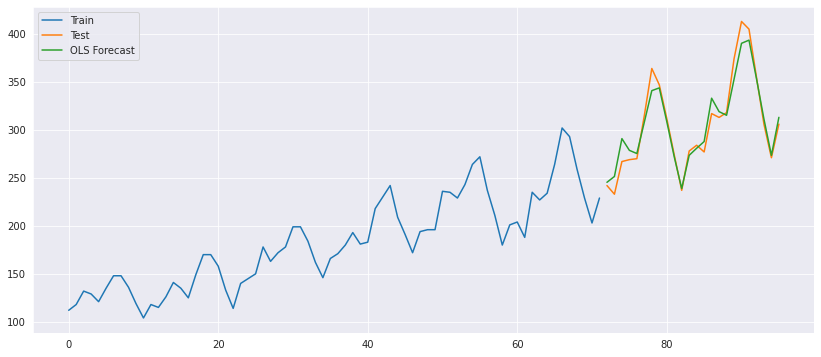

In [135]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [136]:
data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

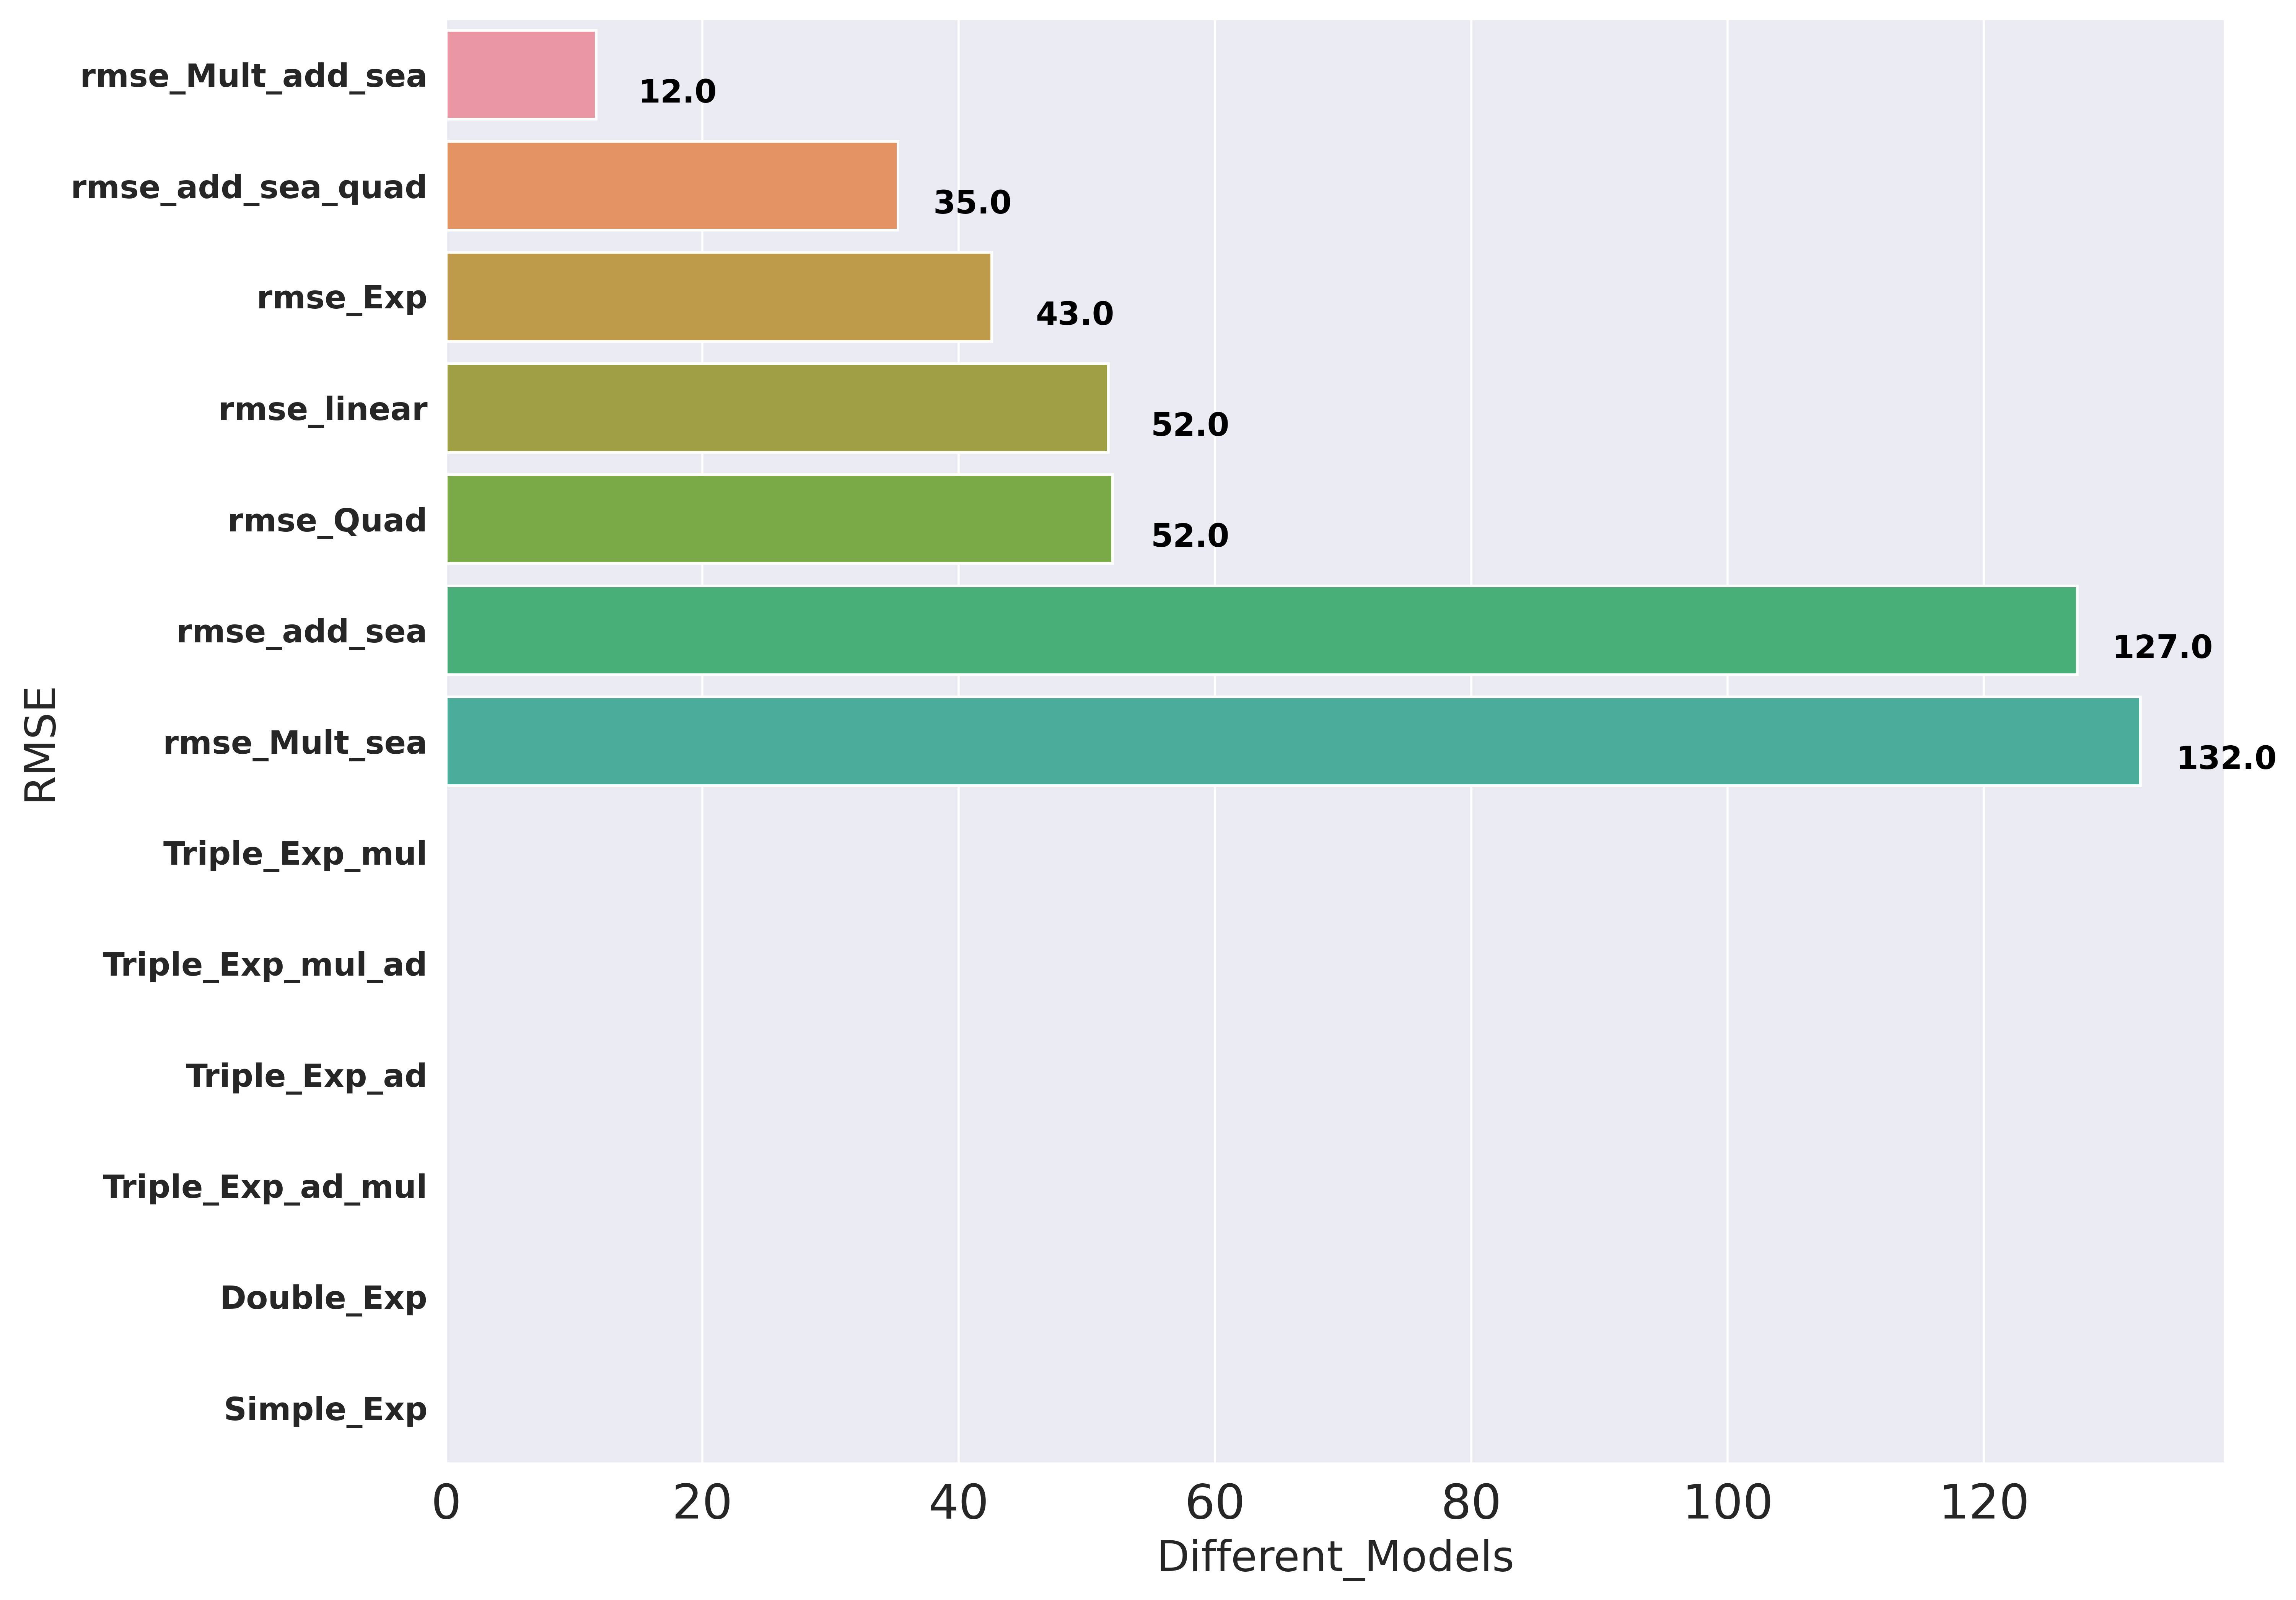

In [139]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()